### Project description


Bread and Salе chain supermarket introduces a computer vision system for processing customers' photos. Photo fixation in the checkout area will help determine the age of customers in order to:
* Analyze purchases and offer products that may be of interest to buyers of this age group;
* Control the conscientiousness of cashiers when selling alcohol.
* Build a model that will determine the approximate age of a person from a photo. At your disposal is a set of photographs of people with age indication.

# 1. Exploratory data analysis

In [1]:
# imports
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt

In [2]:
# data loading
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

In [3]:
# information
labels.info()

Dataset contains 7591 photos

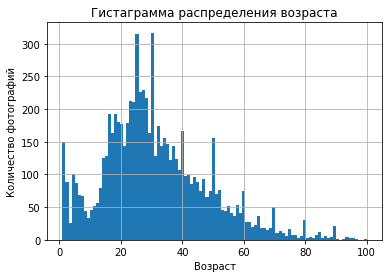

In [4]:
# age distribution histogram
labels.hist(bins=100)
plt.title('Гистаграмма распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

Conclusions:

* The age of people is scattered over a wide range from 1 to 100 years.
* Judging by the histogram, the age of people in the photographs is not evenly distributed, strongly shifted in the range from 15 to 50 years
* Mean age is fairly close to the median.
* There are quite a few photographs of people over 60 years old, this may affect the quality of the model.

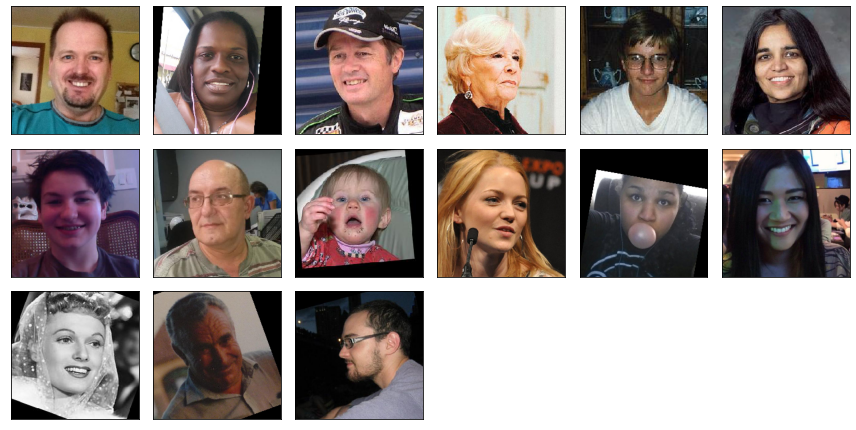

In [6]:
# Output 15 photos to view the dataset device
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(12,10))
for i in range(15):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Conclusion:

* The dataset is quite diverse, photos of different colors, both old and new, both black and white and color.
* Some of the images are rotated at different angles
* On the faces of people, different facial expressions and accessories (glasses, braces, hats, etc.)
* Some of the faces in the dataset are not shown in full, or in half-profile.

# 2. Model Training

In [7]:
def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_gen_flow

In [8]:
def create_model(input_shape):
    optimizer = Adam(0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-08-16 03:22:20.739138: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-08-16 03:22:20.771714: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099995000 Hz
2022-08-16 03:22:20.773707: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x46afd00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-16 03:22:20.773734: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-16 03:22:20.999636: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x45d0af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-08-16 03:22:20.999675: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-08-16 03:22:21.002059: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-16 03:22:21.002116: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-16 03:22:21.002126: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-16 03:22:21.002154: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-08-16 03:22:21.002165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-08-16 03:22:21.002175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-08-16 03:22:21.002186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-08-16 03:22:21.002193: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-08-16 03:22:21.006571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-08-16 03:22:21.008221: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-08-16 03:22:24.371334: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-08-16 03:22:24.371383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-08-16 03:22:24.371391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-08-16 03:22:24.375568: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 03:22:24.375623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 3s
  229376/94765736 [..............................] - ETA: 21s
 1245184/94765736 [..............................] - ETA: 7s 
 4145152/94765736 [>.............................] - ETA: 4s
 4202496/94765736 [>.............................] - ETA: 7s
 6299648/94765736 [>.............................] - ETA: 6s
 8396800/94765736 [=>............................] - ETA: 5s
10526720/94765736 [==>...........................] - ETA: 5s
12591104/94765736 [==>...........................] - ETA: 5s
14753792/94765736 [===>..........................] - ETA: 5s
16785408/94765736 [====>.........................] - ETA: 4s
18964480/94765736 [=====>........................] - ETA: 4s
20979712/94765736 [=====>........................] - ETA: 4s
23191552/94765736 [======>.......................] - ETA: 4s
25174016/94765736 [======>.......................] - ETA: 4s
27402240/94765736 [=======>......................] - ETA: 4s
29368320/94765736 [========>.....................] - ETA: 3s
31612928/94765736 [=========>....................] - ETA: 3s
33562624/94765736 [=========>....................] - ETA: 3s
35823616/94765736 [==========>...................] - ETA: 3s
37756928/94765736 [==========>...................] - ETA: 3s
40050688/94765736 [===========>..................] - ETA: 3s
41951232/94765736 [============>.................] - ETA: 3s
44244992/94765736 [=============>................] - ETA: 2s
46145536/94765736 [=============>................] - ETA: 2s
48455680/94765736 [==============>...............] - ETA: 2s
50339840/94765736 [==============>...............] - ETA: 2s
52666368/94765736 [===============>..............] - ETA: 2s
54534144/94765736 [================>.............] - ETA: 2s
56877056/94765736 [=================>............] - ETA: 2s
58728448/94765736 [=================>............] - ETA: 2s
61087744/94765736 [==================>...........] - ETA: 1s
61218816/94765736 [==================>...........] - ETA: 1s
62824448/94765736 [==================>...........] - ETA: 1s
62922752/94765736 [==================>...........] - ETA: 1s
64069632/94765736 [===================>..........] - ETA: 1s
65232896/94765736 [===================>..........] - ETA: 1s
66379776/94765736 [====================>.........] - ETA: 1s
67117056/94765736 [====================>.........] - ETA: 1s
68263936/94765736 [====================>.........] - ETA: 1s
69427200/94765736 [====================>.........] - ETA: 1s
70574080/94765736 [=====================>........] - ETA: 1s
71311360/94765736 [=====================>........] - ETA: 1s
72458240/94765736 [=====================>........] - ETA: 1s
73621504/94765736 [======================>.......] - ETA: 1s
74784768/94765736 [======================>.......] - ETA: 1s
75505664/94765736 [======================>.......] - ETA: 1s
76652544/94765736 [=======================>......] - ETA: 1s
77815808/94765736 [=======================>......] - ETA: 1s
78979072/94765736 [========================>.....] - ETA: 1s
79699968/94765736 [========================>.....] - ETA: 1s
80863232/94765736 [========================>.....] - ETA: 0s
82026496/94765736 [========================>.....] - ETA: 0s
83206144/94765736 [=========================>....] - ETA: 0s
83894272/94765736 [=========================>....] - ETA: 0s
85057536/94765736 [=========================>....] - ETA: 0s
86253568/94765736 [==========================>...] - ETA: 0s
87433216/94765736 [==========================>...] - ETA: 0s
88088576/94765736 [==========================>...] - ETA: 0s
89268224/94765736 [===========================>..] - ETA: 0s
90464256/94765736 [===========================>..] - ETA: 0s
91660288/94765736 [============================>.] - ETA: 0s
92282880/94765736 [============================>.] - ETA: 0s
93478912/94765736 [============================>.] - ETA: 0s
94691328/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 7s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-08-16 03:22:52.923634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-16 03:22:55.160268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 65s - loss: 260.2211 - mae: 11.4992 - val_loss: 1081.6327 - val_mae: 28.3126
Epoch 2/15
178/178 - 37s - loss: 66.2633 - mae: 6.0933 - val_loss: 752.8580 - val_mae: 22.3926
Epoch 3/15
178/178 - 37s - loss: 30.9284 - mae: 4.2776 - val_loss: 361.1235 - val_mae: 14.2706
Epoch 4/15
178/178 - 37s - loss: 18.3790 - mae: 3.3040 - val_loss: 134.5086 - val_mae: 9.0885
Epoch 5/15
178/178 - 37s - loss: 14.1401 - mae: 2.9276 - val_loss: 82.6844 - val_mae: 6.8500
Epoch 6/15
178/178 - 37s - loss: 11.6780 - mae: 2.6451 - val_loss: 67.9771 - val_mae: 6.2670
Epoch 7/15
178/178 - 37s - loss: 9.4196 - mae: 2.3259 - val_loss: 71.9963 - val_mae: 6.3816
Epoch 8/15
178/178 - 37s - loss: 8.1810 - mae: 2.1424 - val_loss: 84.9675 - val_mae: 6.9925
Epoch 9/15
178/178 - 37s - loss: 7.8414 - mae: 2.0801 - val_loss: 79.4942 - val_mae: 6.7203
Epoch 10/15
178/178 - 37s - loss: 7.0546 - mae: 1.9919 - val_loss: 66.7494 - val_mae: 6.2002
Epoch 11/15
178/178 - 37s - loss: 6.2665 - mae: 1.8856 - val_loss: 67.8516 - val_mae: 6.2162
Epoch 12/15
178/178 - 37s - loss: 5.6207 - mae: 1.8076 - val_loss: 65.3094 - val_mae: 6.1513
Epoch 13/15
178/178 - 37s - loss: 5.5851 - mae: 1.7941 - val_loss: 74.0784 - val_mae: 6.4315
Epoch 14/15
178/178 - 37s - loss: 5.4123 - mae: 1.7680 - val_loss: 84.2371 - val_mae: 6.9070
Epoch 15/15
178/178 - 37s - loss: 5.4687 - mae: 1.7768 - val_loss: 64.0172 - val_mae: 6.0234
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 64.0172 - mae: 6.0234
Test MAE: 6.0234

The average MAE in the model turned out to be below 8.


# 3. Model training analysis


The following parameters were used to create the model:

* The training step equal to 0.0001 affected the speed of the model calculation, but led to its improvement.
* The model was calculated at 15 epochs.
* The Adam optimizer was used in the model
* The model was pretrained on ImageNet. Backbone weight freeze was not applied

As a result, it was possible to achieve the required metrics. The required MAE was achieved at the 6th epoch (6.85).


# 4. Conclusion

To solve the problem of a chain supermarket, a model was built to determine the age of buyers from a photograph. A neural network was trained on the model, thanks to which it was possible to obtain an acceptable MAE metric below 8. This model will help the Bread and Salt network supermarket to determine the age of people from the database of customer photos for different tasks, and with the accumulation of the database, it will improve the quality of the model.